In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import StandardScaler
from utils import make_fan
from DAE import DenoisingAutoencoder
import copy

# Denoising Autoencoder


An autoencoder is a neural network designed to learn to map a high dimensional data point $\bf{x}$ to a low dimensional representation. Thus, this model can be used for many task, such as, for example, compressing data or learning invariante features from high dimensional data. In its origin, they were also used as a pretraining step before training a neural network on supervised data.

The main idea is very simple. We take a datapoint $\bf{x}$ and feed it through a neural network that starts reducing dimensionality. For example if we have a $784$ dimensional datapoint we might feed it into a neural network that has $3$ hidden layers with $512$, $256$ and $128$ neurons per layer. This first neural network is called the encoder. Then, starting from the hidden representation we go back to the original dimension by reverting the operations. So we have a second neural network that takes as input a $128$ and has three layers of $256$,$512$ and $784$.

The task of this two neural networks is to take as input a feature, map it into a low dimensional representation, and then reconstruct back the original input. Thus, the loss function used to train this model is the sum of squared errors between the output of the model and the input. In other words:

$$
\begin{align*}
\frac{1}{N}\sum^N_{n=1}(\text{Decoder}\left(\text{Encoder}(\bf{x}_n)\right) - \bf{x}_n)^2
\end{align*}
$$

One of the problems of the standard autoencoder is that if expressive enough, it can just learn to copy the input to the output, without extracting meaningful information from the data into the latent representation. 

Thus, Denoising Autoencoders learn to map a noisy version of the input into its clean version. In this process, the model learn to clean the noise and for this it needs to extract and encode meaningful information from the input in order to reconstruct the clean output. 

As far as I know, the most popular version of Denoising Autoencoders used zero mean Gaussian noise with $\sigma^2_s$ variance. Thus the learning objective now is:

$$
\begin{align*}
&\tilde{\bf{x}}_n = \bf{x}_n + \epsilon;\, \epsilon \sim \mathcal{N}(0,\sigma^2_s)\\
&\frac{1}{N}\sum^N_{n=1}(\text{Decoder}\left(\text{Encoder}(\tilde{\bf{x}}_n)\right) - \bf{x}_n)^2
\end{align*}
$$


One of the cool things about a denoising autoencoder is that it implicitly defines a distribution over $p(\bf{x})$ from which we can sample using Markov Chain Monte Carlo.


## Training a DAE

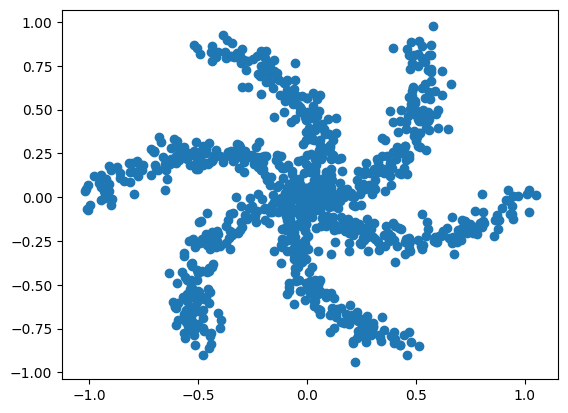

In [2]:
X_data = make_fan(n_samples = 1000)

plt.plot(X_data[:,0],X_data[:,1], 'o')

#### Defining a Denoising Autoencoder

In [3]:
encoder_layers = [
    (2, 5, nn.Tanh),
    (5, 10, nn.Tanh),
]

decoder_layers = [
    (10, 5, nn.Tanh),
    (5, 2, None),   # with linear activation
]

## Autoencoder
DAE = DenoisingAutoencoder(encoder_layers, decoder_layers)



#### Prepare a Torch Dataset and Dataloader

In [4]:
## Normalize data and create torch dataloader
scaler = StandardScaler()
X = scaler.fit_transform(X_data)

X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

#### Decide on the sampling noise parameter

While in high dimensional data is usually complicate to decide $\sigma^2_s$ by sampling, here we can randomly generate some data and see how it looks.


In [5]:
%matplotlib tk
try:
    plt.close("all")
except:
    pass
    
## A utility function to add noise
def add_noise(x, std):
    return x + std * torch.randn_like(x)

plt.plot(X_data[:,0],X_data[:,1], 'o', color = 'C0')

sigma_s = 0.1
std_s = np.sqrt(sigma_s)

for (x,) in loader:
    x_noisy = add_noise(x, std_s)
    
    ## denormalize before plotting
    x_plot = scaler.inverse_transform(x_noisy)
    plt.plot(x_plot[:,0],x_plot[:,1], 'x', color = 'C1')
    plt.pause(0.1)

%matplotlib inline

#### Training a DAE

In [6]:
## training DAE
device = 'cpu'
DAE = DAE.to(device)
optimizer = optim.Adam(DAE.parameters(), lr=1e-4)
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9)
criterion = nn.MSELoss()

epochs = 400
sigma_s = 0.1
std_s = np.sqrt(sigma_s)

for epoch in range(epochs):
    total_loss = 0
    for (x,) in loader:
        x = x.to(device)
        x_noisy = add_noise(x, std_s)

        x_hat = DAE(x_noisy)
        loss = criterion(x_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, loss {total_loss/len(loader):.4f}")

Epoch 10, loss 1.1503
Epoch 20, loss 1.0921
Epoch 30, loss 1.0372
Epoch 40, loss 0.9814
Epoch 50, loss 0.9336
Epoch 60, loss 0.8956
Epoch 70, loss 0.8512
Epoch 80, loss 0.8153
Epoch 90, loss 0.7815
Epoch 100, loss 0.7422
Epoch 110, loss 0.7102
Epoch 120, loss 0.6744
Epoch 130, loss 0.6379
Epoch 140, loss 0.6037
Epoch 150, loss 0.5625
Epoch 160, loss 0.5316
Epoch 170, loss 0.4913
Epoch 180, loss 0.4597
Epoch 190, loss 0.4212
Epoch 200, loss 0.3908
Epoch 210, loss 0.3582
Epoch 220, loss 0.3339
Epoch 230, loss 0.3053
Epoch 240, loss 0.2827
Epoch 250, loss 0.2654
Epoch 260, loss 0.2416
Epoch 270, loss 0.2342
Epoch 280, loss 0.2169
Epoch 290, loss 0.2099
Epoch 300, loss 0.2021
Epoch 310, loss 0.1929
Epoch 320, loss 0.1827
Epoch 330, loss 0.1849
Epoch 340, loss 0.1821
Epoch 350, loss 0.1732
Epoch 360, loss 0.1714
Epoch 370, loss 0.1704
Epoch 380, loss 0.1641
Epoch 390, loss 0.1622
Epoch 400, loss 0.1623


## Generating samples from a DAE using MCMC through iterative denoising, Bengio 2013

Main reference: https://arxiv.org/pdf/1305.6663

One of the cool things of Denoising Autoencoders is that we can sample from the distribution $p(\bf{x})$ implicitly learnt by the model using Markov Chain Monte Carlo. In particular we use a Gibbs sampler. Each step in the Markov Chain is generated as follows:

* Sample from the corruption conditional distribution $C(\tilde{\bf{x}}\mid \bf{x}) = \mathcal{N}(\tilde{\bf{x}}\mid \bf{x},\sigma^2_s)$
* Sample from the denoising conditional distribution $p(\bf{x} \mid \text{DAE}(\tilde{x}),\sigma^2_r)$ 

Starting from a random sample $\bf{x_0}$ we corrupt this sample using the training noisy proceedure, i.e zero mean Gaussian with variance given by $\sigma^2_s$. Then we feed this sample into the Neural network to obtain the denoised version. This denoised version is used as the mean from a Gaussian distribution with a variance given by $\sigma^2_r$, from which we draw a sample. Starting from this sample we repeat the procedure. After several steps the generated sample is a sample from $p(\bf{x})$.

As with Contrastive Divergence for Restricted Boltzman machines, we can start the chain from a training datapoint. However, since the dimensionality of the data is low in this example, starting from a random sample.



#### Estimate Reconstruction Noise

Reconstruction noise $\sigma^2_r$ is given by the coordinate update on the sigma parameter, which is the empirical variance.

$$
\begin{align*}
\mu(x_n) &= \text{DAE}(\tilde{x_n})\\
\sigma_o^2 &= \frac{1}{N}\sum_{n=1}^N (x_n - \mu(x_n))^2
\end{align*}
$$

This comes from the fact that the training objective of a Denoising Autoencoder implicitely learns a Conditional Gaussian distribution with constant noise. Thus, maximizing this distribution w.r.t the variance yields the above coordinate update.

In reality, we should estimate a single noise parameter per datapoint we condition on. This is unfeasible since we have infinite datapoints. So ideally we would need to, for each point in the domain, estimate the variance by adding different sampled noise to a point, get the reconstructions, and compute the empirical variance. 

For efficiency, we will just compute one single parameter adding noise several times to the different inputs.

In [7]:
N_times = 5 # number of times we add noise

sigma_o = torch.zeros(1,2)
N = 0.0

with torch.no_grad():
    for n_times in range(N_times):
        for (x,) in loader:
            x = x.to(device)

            ## generate \tilde{x_n}
            x_noisy = add_noise(x, std_s)

            ## mu(\tilde(x))
            x_hat = DAE(x_noisy)

            ## accumulate on sigma_o
            sigma_o += torch.sum((x-x_hat)**2, axis = 0)
            
            N += x.shape[0]

## compute average
sigma_o *= 1/N

# for sampling we use standard dev
std_o = torch.sqrt(sigma_o)

print(sigma_o.shape)
print(sigma_o)  
print(std_o)

torch.Size([1, 2])
tensor([[0.1707, 0.1557]])
tensor([[0.4131, 0.3946]])


#### Run MCMC

In [8]:
%matplotlib tk
try:
    plt.close("all")
except:
    pass

# draw original dataset
fig, ax = plt.subplots(1,1)
ax.plot(X_data[:,0],X_data[:,1], 'o', 'C0')


# MCMC using iterative denoising
n_chains = 1
for chain in range(n_chains):
    # Initial sample to run the chain. Ideally we can draw the sample at whatever place but the best is to do 
    # it next to the domain, or in a sample as with CD. However since 2D and data is centered random gaussian
    # is good.
    x_s = torch.randn(1,2)
    
    # plot
    ax.plot(x_s[:,0],x_s[:,1], 'o', color = f'C{chain+1}', zorder = 200)
        
    steps = 100
    for step in range(steps):
        with torch.no_grad():
    
            ## =========================
            # Sample from C(x_noise | x)
            x_s = add_noise(x_s, std_s)
    
            ## ==============================
            ## Get parameters from P(x|x_noise)
            x_s = x_s.to(device)
            mu_xs = DAE(x_s)
    
            # draw a sample using sigma_r
            x_s = add_noise(mu_xs, std_o)
    
            # un normalize since we have trained on normalized space
            X_plot = scaler.inverse_transform(x_s)
    
            ## Plot chain step
            ax.plot(X_plot[:,0],X_plot[:,1], 'x',  color = f'C{chain+1}', zorder = 200)
    
            plt.pause(0.2)
    
    ## Plot sample.
    ax.plot(X_plot[:,0],X_plot[:,1], 'o', markersize = 10, color = f'C{chain+1}', zorder = 200)
    plt.pause(0.2)

%matplotlib inline

In [9]:
plt.close("all")

## Generating samples from a DAE using Langevin MCMC, Alain 2013

**Main reference:** https://arxiv.org/pdf/1211.4246

Langevin MCMC generate samples by creating a markov chain with the following transition:

$$
\begin{align*}
x_{t+1} = x_t + \frac{\epsilon}{2}\nabla_x \log p(x) + \sqrt{\epsilon}z_t
\end{align*}
$$

with $z_t \sim \mathcal{N}(0,I)$. So rather than using the conditional distributions to run MCMC as with Gibbs sampling, it performs MCMC by taking the sample paths defined by the gradient of the log-probability, corrupting them with Gaussian Noise. This is, basically, the discretization of a stochastic differential equation.

The score function, which is the gradient of the log-probability $\nabla_x p(x)$, can be obtained under certain circumstances (for example the corruption noise being Gaussian), in the following limit:

$$
\begin{align*}
\nabla_x \log p(x) = \frac{\text{DAE}_{\sigma_s^2}(\tilde{x})-\tilde{x}}{\sigma_s^2}; \, \sigma \rightarrow 0
\end{align*}
$$

So we can train a denoising autoencoder and run Langevin MCMC to draw samples.

#### Generate data


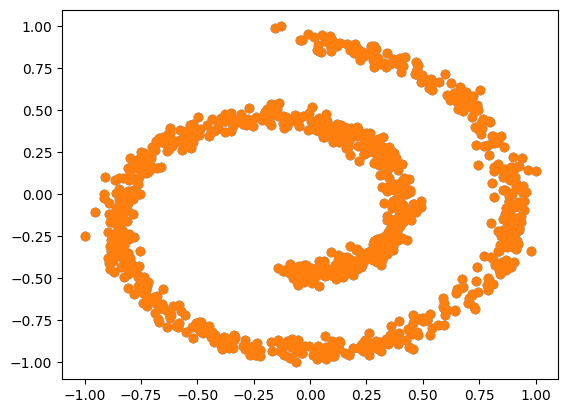

In [10]:
%matplotlib inline
try:
    plt.close("all")
except:
    pass
    
X_data, t = make_swiss_roll(noise=0.5, n_samples = 1000)
X_data = np.delete(X_data, 1, axis=1)

X_min = X_data.min(axis=0)
X_max = X_data.max(axis=0)

X_data = 2 * (X_data - X_min) / (X_max - X_min) - 1

plt.plot(X_data[:,0],X_data[:,1], 'o')

plt.plot(X_data[:,0],X_data[:,1], 'o')
plt.show()

#### Prepare a Torch Dataset and Dataloader

In [11]:
## Normalize data and create torch dataloader
scaler = StandardScaler()
X = scaler.fit_transform(X_data)

X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=5000, shuffle=True)

#### Define a Denoising Autoencoder

In [12]:
## A utility function to add noise
def add_noise(x, std):
    return x + std * torch.randn_like(x)

encoder_layers = [
    (2, 100, nn.Tanh),
]

decoder_layers = [
    (100, 2, None),   # with linear activation
]

## Autoencoder
DAE = DenoisingAutoencoder(encoder_layers, decoder_layers)

#### Train a Denoising Autoencoder

Now we use a small noise corruption term, based on the theory


In [13]:
## training DAE
device = 'cpu'
DAE = DAE.to(device)
optimizer = optim.Adam(DAE.parameters(), lr=1e-2)
criterion = nn.MSELoss()

epochs = 800
sigma_s = 0.0001
std_s = np.sqrt(sigma_s)

for epoch in range(epochs):
    total_loss = 0
    for (x,) in loader:
        x = x.to(device)
        x_noisy = add_noise(x, std_s)

        x_hat = DAE(x_noisy)
        loss = criterion(x_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, loss {total_loss/len(loader):.10f}")

Epoch 10, loss 0.2736474574
Epoch 20, loss 0.0698620901
Epoch 30, loss 0.0094206426
Epoch 40, loss 0.0033149451
Epoch 50, loss 0.0031964520
Epoch 60, loss 0.0024843090
Epoch 70, loss 0.0018326344
Epoch 80, loss 0.0014453620
Epoch 90, loss 0.0012160930
Epoch 100, loss 0.0010397725
Epoch 110, loss 0.0009430154
Epoch 120, loss 0.0008241666
Epoch 130, loss 0.0007868341
Epoch 140, loss 0.0007408420
Epoch 150, loss 0.0006706789
Epoch 160, loss 0.0006299145
Epoch 170, loss 0.0006022964
Epoch 180, loss 0.0005618305
Epoch 190, loss 0.0005127266
Epoch 200, loss 0.0004928205
Epoch 210, loss 0.0004781556
Epoch 220, loss 0.0004294109
Epoch 230, loss 0.0004321540
Epoch 240, loss 0.0003997603
Epoch 250, loss 0.0003950935
Epoch 260, loss 0.0003769794
Epoch 270, loss 0.0003521985
Epoch 280, loss 0.0003372246
Epoch 290, loss 0.0003506959
Epoch 300, loss 0.0003180376
Epoch 310, loss 0.0003158782
Epoch 320, loss 0.0003019212
Epoch 330, loss 0.0002865856
Epoch 340, loss 0.0002720985
Epoch 350, loss 0.00027

#### Vector field defined by the score function

Note that $\nabla_x \log p(\bf{x})$ defines a vector field over the domain. Each point in the domain has a gradient $\nabla_x \log p(\bf{x})$ which points in the direction of high probability $p(\bf{x})$, by definition. We can plot it

In [14]:
## lets first draw the vector field obtained from the score at each point. 
def plot_score_field(dae, sigma, scaler, xlim=(-1.1, 1.1), ylim=(-1.1, 1.1), grid_size=20, device='cpu'):
    ## assited by chatGPT 
    xs = np.linspace(xlim[0], xlim[1], grid_size)
    ys = np.linspace(ylim[0], ylim[1], grid_size)
    X, Y = np.meshgrid(xs, ys)
    points = np.stack([X.ravel(), Y.ravel()], axis=1)
    points_t = torch.tensor(scaler.transform(points), dtype=torch.float32).to(device)
    #points_t = torch.tensor(points, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        recon = dae(points_t)
    
    score = (recon - points_t) / sigma

    # divide by sigma to obtain score in original un normalized space. Chain rule    
    #score_np = score.cpu().numpy()
    score_np = score.cpu().numpy() / scaler.scale_

    return score_np, X, Y
    

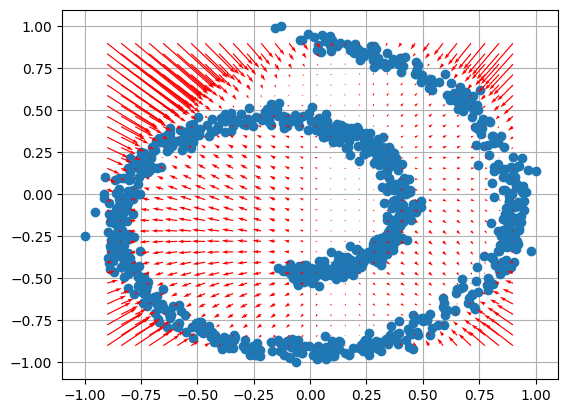

In [15]:
%matplotlib inline
try:
    plt.close("all")
except:
    pass

# draw original dataset
fig, ax = plt.subplots(1,1)
ax.plot(X_data[:,0],X_data[:,1], 'o')

# draw associated vector field
score, X, Y = plot_score_field(DAE, sigma_s, scaler, grid_size=30,  xlim=(-0.9, 0.9), ylim=(-0.9,0.9))
ax.quiver(X, Y, score[:,0], score[:,1], color='r',zorder = 5)
ax.grid(True)

#### Run MCMC

We can now run MCMC

In [16]:
%matplotlib tk
try:
    plt.close("all")
except:
    pass

# draw original dataset
fig, ax = plt.subplots(1,1)
ax.plot(X_data[:,0],X_data[:,1], 'o')

# draw associated vector field
score, X, Y = plot_score_field(DAE, sigma_s, scaler, grid_size=50, xlim=(-1.1, 1.1), ylim=(-1.1,1.1))
ax.quiver(X, Y, score[:,0], score[:,1], color='r',zorder = 5)
ax.grid(True)


# Initial sample to run the chain. Langevin dynamics starts from a sample of a Gaussian distribution.
# However since the score is not going to be good estimated outside the data distribution, then we need
# to initialize close. Thus we reduce the variance of the generated sample
torch.manual_seed(1)
chains = 10
for chain in range(chains):
    X = torch.randn(1,2)
    X_corr = add_noise(X, std_s)
    
    # plot
    ax.plot(X_corr[:,0],X_corr[:,1], 'o', color = f'C{chain+1}', zorder = 200)
    
    # MCMC using Langevin dynamics
    epsilon = 0.001
    steps = 20
    
    for step in range(steps):
        with torch.no_grad():
    
            ## =========================
            # Sample from C(x_noise | x)
            if step != 0:
                X_corr = add_noise(X, std_s)
            else:
                pass
    
            ## ===========================
            # Estimate the score function
            X_corr = X_corr.to(device)
            DAE_s = DAE(X_corr)
            s_x = (DAE_s - X_corr) / sigma_s
    
            ## =s========================================
            ## Generate new sample using a Langevin step
            X = X + (epsilon / 2) * s_x + np.sqrt(epsilon) * torch.randn_like(X)
    
            ## ===============
            ## Plot chain step
            
            # un normalize since we have trained on normalized space
            X_plot = scaler.inverse_transform(X)
            ax.plot(X_plot[:,0],X_plot[:,1], 'x', color = f'C{chain+1}', zorder = 200)
    
            plt.pause(0.2)
    
    ## Plot sample.
    ax.plot(X_plot[:,0],X_plot[:,1], 'o', markersize = 10, color = f'C{chain+1}', zorder = 200)
    plt.pause(0.2)
%matplotlib inline

In [17]:
try:
    plt.close("all")
except:
    pass